## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
# datasets from fastai
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/zed/.fastai/data/camvid/labels'),
 PosixPath('/home/zed/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/zed/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/zed/.fastai/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/zed/.fastai/data/camvid/images/Seq05VD_f00330.png'),
 PosixPath('/home/zed/.fastai/data/camvid/images/0001TP_007590.png'),
 PosixPath('/home/zed/.fastai/data/camvid/images/0016E5_07991.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/zed/.fastai/data/camvid/labels/0001TP_008130_P.png'),
 PosixPath('/home/zed/.fastai/data/camvid/labels/0001TP_007710_P.png'),
 PosixPath('/home/zed/.fastai/data/camvid/labels/0016E5_00510_P.png')]

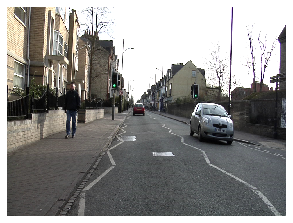

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

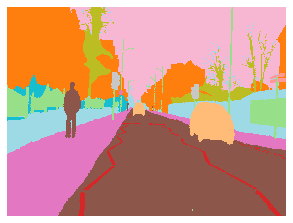

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [12]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
bs = 4
print(f"using bs= 4, have {free}MB of GPU RAM free")

using bs=4, have 7751MB of GPU RAM free


In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

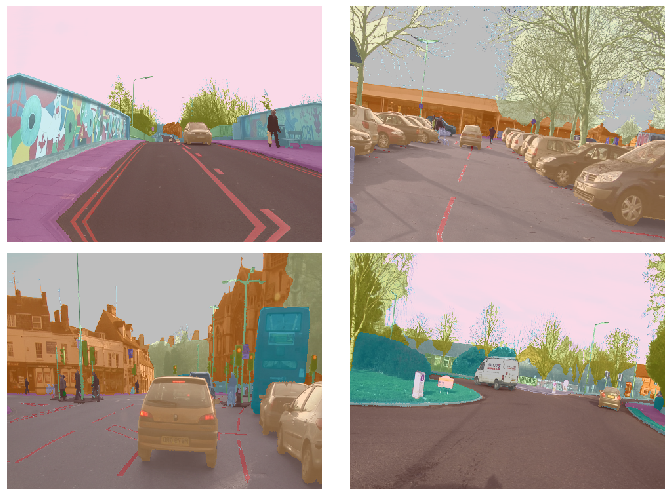

In [15]:
data.show_batch(2, figsize=(10,7))

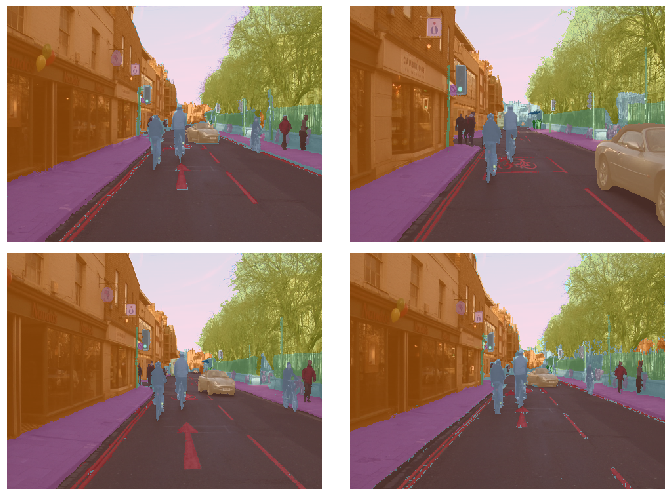

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid
# metrics=accuracy

In [19]:
wd=1e-2

In [20]:
# if you add .to_fp16() at the end of any learner, it will train it in 16 bits
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


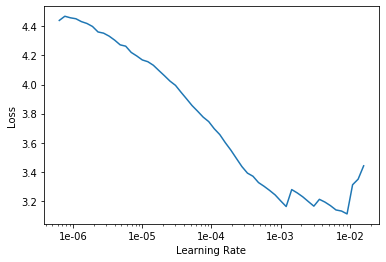

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
lr=3e-3

In [23]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.936187,0.709550,0.821992,01:11
1,0.723679,0.620946,0.841340,01:09
2,0.659297,0.527783,0.861257,01:09
3,0.623973,0.484509,0.867944,01:05
4,0.613453,0.622748,0.845499,01:10
5,0.630504,0.495823,0.862745,01:10
6,0.548438,0.464424,0.878267,01:10
7,0.542516,0.460005,0.873962,01:09
8,0.520702,0.426656,0.873037,01:09
9,0.440892,0.357026,0.891821,01:09


In [24]:
learn.save('stage-1')

In [25]:
learn.load('stage-1');

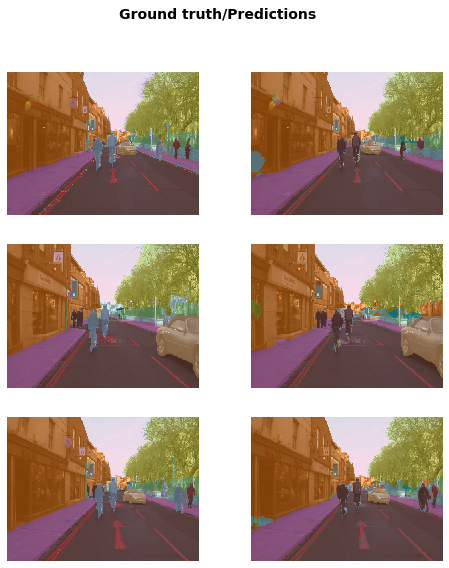

In [26]:
learn.show_results(rows=3, figsize=(8,9))

In [27]:
learn.unfreeze()

In [28]:
lrs = slice(lr/400,lr/4)

In [29]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.410478,0.339707,0.896647,01:13
1,0.391259,0.340193,0.896569,01:13
2,0.389967,0.336442,0.898924,01:13
3,0.380307,0.327071,0.907443,01:13
4,0.366832,0.320965,0.906983,01:13
5,0.368845,0.329098,0.902816,01:13
6,0.365741,0.335360,0.906693,01:13
7,0.359753,0.345791,0.907183,01:13
8,0.366969,0.393677,0.895298,01:13
9,0.367266,0.323661,0.909984,01:09


In [30]:
learn.save('stage-2');

## Go big

if you run out of memory, decrease `bs`.

In [31]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()

bs = 4
print(f"using bs=4, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7223MB of GPU RAM free


In [32]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [33]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [34]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


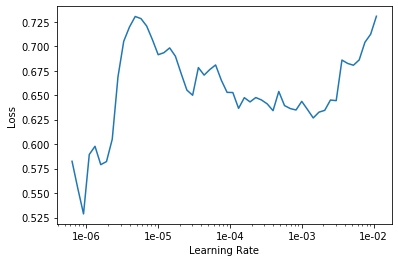

In [35]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr=1e-3

In [37]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.453864,0.357924,0.902351,04:19
1,0.437586,0.349202,0.902822,04:14
2,0.447814,0.322753,0.910149,04:16
3,0.433362,0.387986,0.883776,04:14
4,0.469338,0.399244,0.899199,04:16
5,0.426165,0.349345,0.904174,04:15
6,0.392457,0.339857,0.909399,04:14
7,0.381442,0.374509,0.902728,04:14
8,0.327118,0.274789,0.926746,04:15
9,0.300587,0.280762,0.920968,04:15


In [38]:
learn.save('stage-1-big')

In [39]:
learn.load('stage-1-big');

In [40]:
learn.unfreeze()

In [41]:
lrs = slice(1e-6,lr/10)

In [42]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.254962,0.286503,0.920041,04:32
1,0.310779,0.297421,0.918446,04:31
2,0.268701,0.282014,0.921542,04:31
3,0.290927,0.283706,0.921048,04:31
4,0.278017,0.284583,0.920085,04:31
5,0.272179,0.287899,0.920460,04:33
6,0.238731,0.288816,0.921365,04:31
7,0.241189,0.293922,0.919768,04:31
8,0.239008,0.280938,0.922507,04:32
9,0.238272,0.302304,0.918799,04:31


In [43]:
learn.save('stage-2-big')

In [44]:
learn.load('stage-2-big');

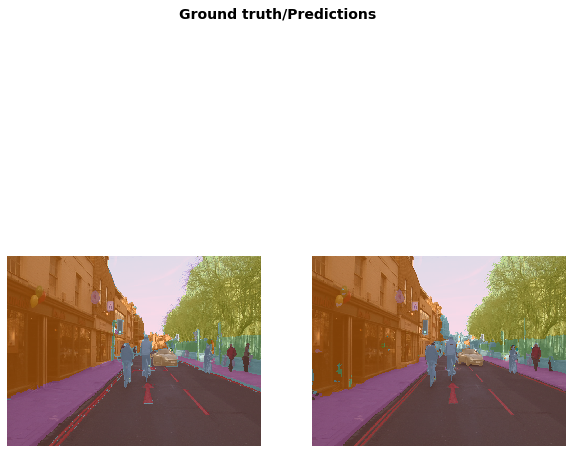

In [45]:
learn.show_results(rows=3, figsize=(10,10))